In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
import feather
import scipy
from scipy.cluster import hierarchy as hc

/Users/joshishushruth/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [3]:
def rmse(x,y) : return math.sqrt(((x-y) ** 2).mean())

def print_score(m,x_train,x_test,y_train,y_test):
    res = [rmse(m.predict(x_train), y_train), rmse(m.predict(x_test), y_test), m.score(x_train, y_train), m.score(x_test,y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return res

## Model Development 
After preprocessing the data, the next step I did is to apply the data we have to a few different models to get a reasonable baseline figure. the `print_score()` method above prints out the RMSE value for the different types of models we try out. 

Since this is a regresssion problem the main models I would go with are:
1. RandomForest
2. XGBoost
3. GradientBoostingRegressor

There are more I could use, and will once I understood them in more depth. But for now let's plug the data we have into a model and see what we get.

In [4]:
df = feather.read_dataframe('./vars/df_post_eda.feather')

In [5]:
X = df.drop('SalePrice', axis = 1)
y = df.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y)

### RandomForest
After spiltting the training set, we can create the most basic RandomForest regression without any parameters, and see we get a test accuracy (last value in the array) of **84.3%**, and the RMSE is **$31335.08**. This it a pretty decent start for a model without any data manipulation.

In [6]:
rf = RandomForestRegressor(n_jobs=-1, random_state=19)
rf.fit(X_train, y_train)
print_score(rf, X_train, X_test, y_train, y_test)

[14009.710216937288, 31335.075785009707, 0.9688729896298164, 0.8438923928882374]


[14009.710216937288,
 31335.075785009707,
 0.9688729896298164,
 0.8438923928882374]

### XGBoost
The other model we can try is the XGBoost model, this is powerful gradient boosting model built to be more computationally efficient and improved performance.
I entered some basic parameters to get a baseline value here (we will use it more further down), and we already see an improvement from the RandomForest Regressor. with a accuracy of **87%**, and a better RMSE.

In [7]:
xg = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 50, alpha = 0.5, n_estimators = 200, random_state=19)
xg.fit(X_train, y_train)
print_score(xg, X_train, X_test, y_train, y_test)

[0.6587124690551518, 27610.56530788169, 0.9999999999311869, 0.8787970570424355]


[0.6587124690551518, 27610.56530788169, 0.9999999999311869, 0.8787970570424355]

## Hyperparameter Tuning
We can try to get the best tuning parameters for the RandomForestRegressor and see if that impacts the score at all.

Trees 30
[12481.867374653422, 26488.257427350047, 0.9755710648579576, 0.8847730596021632, 0.8372787564376155]

Trees 50
[11940.438289059228, 27017.654083237263, 0.977644419788878, 0.8801211612773765, 0.853668541308993]

Trees 100
[11261.43524994273, 26708.25397744155, 0.9801146656627873, 0.8828510910549333, 0.8579683497058299]

Trees 200
[10936.135145733664, 26686.471831128445, 0.9812468966938875, 0.8830420967361341, 0.8646941232306553]

Trees 500
[11036.021808391095, 26718.51597958106, 0.980902764261014, 0.8827610504772129, 0.8622531824503487]

Trees 1000
[10882.186649592266, 26740.159249470227, 0.981431460311758, 0.8825710352870546, 0.8634497616074719]

Trees 2000
[10815.234764672363, 26695.887597058714, 0.9816592407066435, 0.8829595498543992, 0.8644380436651045]



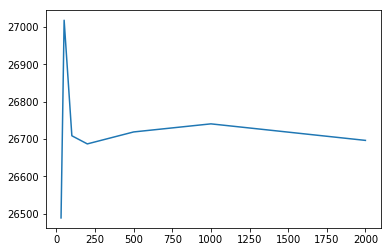

In [50]:
# Hyperparemeter tests.

results = []
n_estimator_options = [30,50,100,200,500,1000,2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(n_estimators=trees, oob_score=True, n_jobs=-1, random_state=19)
    model.fit(X_train, y_train)
    print("Trees", trees)
    score =  print_score(model, X_train, X_test, y_train, y_test)
    results.append(score[1])
    print("")
    
pd.Series(results, n_estimator_options).plot()

Features auto
[10936.135145733664, 26686.471831128445, 0.9812468966938875, 0.8830420967361341, 0.8646941232306553]

Features None
[10936.135145733664, 26686.471831128445, 0.9812468966938875, 0.8830420967361341, 0.8646941232306553]

Features sqrt
[11684.429975406973, 27320.240937510785, 0.9785927702800484, 0.8774209352434938, 0.8482613642678583]

Features log2
[11715.387182457984, 27027.88250312429, 0.9784791856298544, 0.8800303759562005, 0.8464912081938201]

Features 0.5
[10860.221207826542, 26489.8743501724, 0.9815063449936879, 0.884758991575473, 0.8672775703996689]

Features 0.9
[11057.85018298682, 26662.474266357534, 0.9808271439184156, 0.8832523488013011, 0.8616477540751812]

Features 0.2
[11055.330339170507, 26414.22251214895, 0.9808358810775094, 0.8854162800880878, 0.8637886679398583]



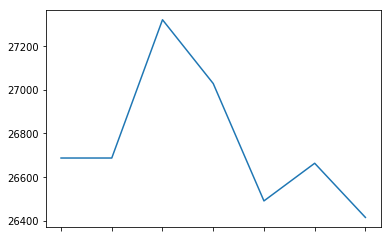

In [51]:
results = []
max_features = ['auto', None, 'sqrt','log2', 0.5, 0.9, 0.2]

for feature in max_features:
    model = RandomForestRegressor(n_estimators=200, max_features=feature, oob_score=True, n_jobs=-1, random_state=19)
    model.fit(X_train, y_train)
    print("Features", feature)
    score =  print_score(model, X_train, X_test, y_train, y_test)
    results.append(score[1])
    print("")
pd.Series(results, max_features).plot()

Leaf 1
[11055.330339170507, 26414.22251214895, 0.9808358810775094, 0.8854162800880878, 0.8637886679398583]

Leaf 2
[15402.040970567281, 26990.87456694353, 0.9628035102106082, 0.8803586879186114, 0.8485437642477701]

Leaf 3
[19007.426647086722, 27117.427940525195, 0.943351025107765, 0.8792341220724696, 0.8437922099737899]

Leaf 4
[22136.452538832506, 27296.688219746764, 0.9231645820073442, 0.8776321944087617, 0.8365871169509274]

Leaf 5
[23797.619810878783, 27797.900111169598, 0.9112001048372553, 0.873097191583976, 0.8384770157525784]

Leaf 6
[25170.400778600935, 28255.62723033745, 0.9006596534978579, 0.8688835572465458, 0.8304713574813045]

Leaf 7
[26319.98591317331, 28482.523958228565, 0.8913782703411901, 0.8667693348629353, 0.8302834307175748]

Leaf 8
[27111.15756763384, 28880.409163022858, 0.884749841520487, 0.8630210171640672, 0.8282093094924775]

Leaf 9
[28028.35975532343, 29314.472907632906, 0.8768198367040769, 0.8588725700446688, 0.8223706474534259]

Leaf 10
[28579.37580528812, 

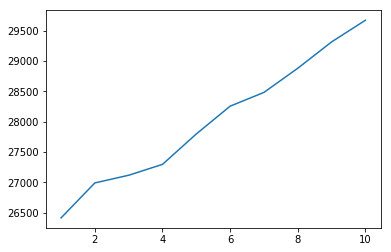

In [52]:
results = []
min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]

for leaf in min_samples_leaf:
    model = RandomForestRegressor(n_estimators=200, max_features=0.2, min_samples_leaf=leaf, oob_score=True, n_jobs=-1, random_state=19)
    model.fit(X_train, y_train)
    print("Leaf", leaf)
    score =  print_score(model, X_train, X_test, y_train, y_test)
    results.append(score[1])
    print("")
pd.Series(results, min_samples_leaf).plot()

## Results

By getting the best parameters for the RandomForestRegressor we went up **~4%**, this may not seem like much but it's pretty good.

In [53]:
model = RandomForestRegressor(n_estimators=200, max_features=0.2, min_samples_leaf=1, oob_score=True, n_jobs=-1, random_state=19)
model.fit(X_train, y_train)
print_score(model, X_train, X_test, y_train, y_test)

[11055.330339170507, 26414.22251214895, 0.9808358810775094, 0.8854162800880878, 0.8637886679398583]


[11055.330339170507,
 26414.22251214895,
 0.9808358810775094,
 0.8854162800880878,
 0.8637886679398583]

### Getting the Important Features
Understanding what features made the most impact on the model, can be useful when we revisit the EDA phase of the project, as we can gather more insights based on the important features.

It's no surprise that the Overall Quality of the house which is a ordinal categorial variable plays a significant part in the model followed by the Ground Living Area and surprisngly the Garage Cars (this may be a feature we need to investigate)

The `area_per_room` and `remod_to_sold_diff` made the top 15 important features which is good to see.

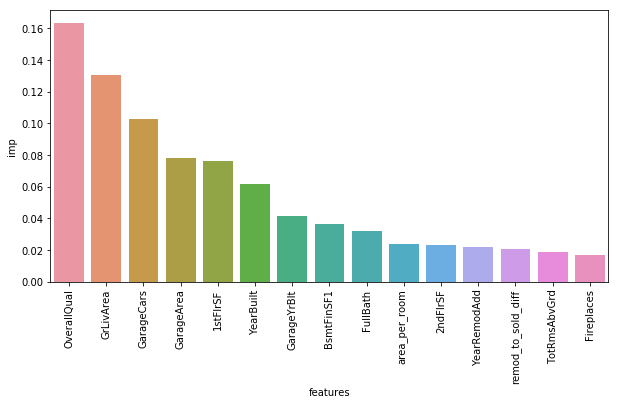

In [60]:
imp_features = (sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), X_test.columns), reverse=True))

imp_df = pd.DataFrame(imp_features, columns=['imp', 'features'])

fig,ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation=90)
sns.barplot(imp_df['features'][:15], imp_df['imp'][:15], ax=ax)

## Dendogram
We can plot dendograms to see the correlations between many features, the graph below shows this. the features that are closely correlated have lower values, and a good test is to remove one of the features to see if this improves our score at all.

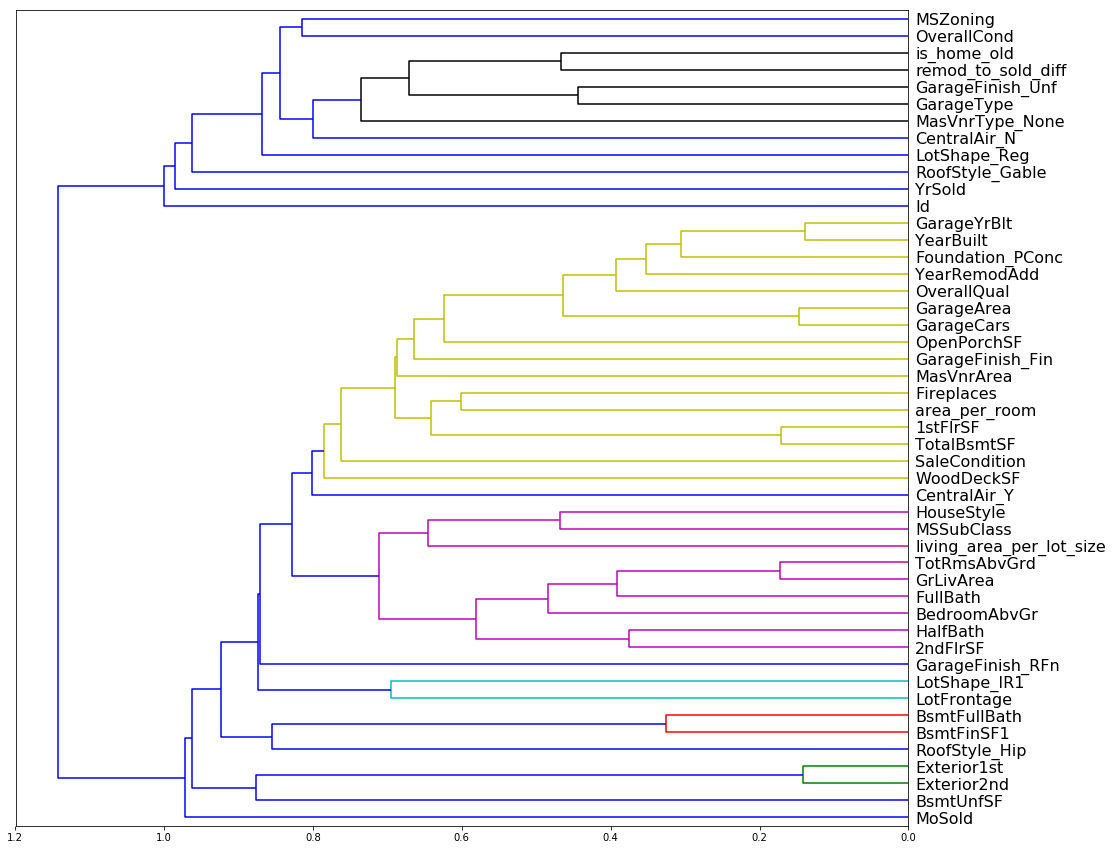

In [14]:
to_keep = imp_df[imp_df.imp > 0.001]
cols = np.array(to_keep['features'])
df_keep_ = X[cols].copy()

corr = np.round(scipy.stats.spearmanr(df_keep_).correlation, 4)
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method = 'average')
fig = plt.figure(figsize=(16,15))
dendogram = hc.dendrogram(z, labels=df_keep_.columns, orientation='left', leaf_font_size=16)

### Removing highly correlated features
We can see below that removing some highly correlated features does improve the accuracy. Removing `TotalBsmtSF` and `Exterior1st` gives a moderate increase in the RMSE. By dropping these features from our model, we get an increase in the RMSE value, but a decrease in our test accuracy, which may have been because we were overfitting in the previous models.

In [57]:
feats = ['GarageYrBlt', 'YearBuilt','GarageArea','GarageCars',
         '1stFlrSF','TotalBsmtSF','BedroomAbvGr', 'Exterior2nd','Exterior1st','TotRmsAbvGrd','GrLivArea']


for f in feats:
    print('Removing Feature...', f)
    df_sub = df_keep_.drop(f, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(df_sub, y)
    model = RandomForestRegressor(n_estimators=200, max_features=0.2, min_samples_leaf=1, oob_score=True, n_jobs=-1)
    model.fit(X_train, y_train)
    print_score(model, X_train, X_test, y_train, y_test)

Removing Feature... GarageYrBlt
[11192.088601959, 30711.973626225023, 0.9808414163574084, 0.8315672794413089, 0.863411329340106]
Removing Feature... YearBuilt
[10829.243557328433, 31934.1510250155, 0.9804700048137367, 0.8585738566091017, 0.8546619676392959]
Removing Feature... GarageArea
[11192.64285220086, 27267.755768823146, 0.9795593691488256, 0.8908589469487134, 0.8510307970578561]
Removing Feature... GarageCars
[11514.367079392667, 28558.621726758094, 0.9790534629964789, 0.8691805075765773, 0.8469547842828542]
Removing Feature... 1stFlrSF
[11190.946727837189, 32181.05409729696, 0.9786767590489454, 0.8633196506178457, 0.8526640384187746]
Removing Feature... TotalBsmtSF
[11457.422386328875, 25472.486064945486, 0.9791761991554657, 0.8969983209238207, 0.8470817782420188]
Removing Feature... BedroomAbvGr
[11110.980639007314, 27175.86059840232, 0.9801873859779316, 0.8869453452458648, 0.8500762608450152]
Removing Feature... Exterior2nd
[11664.473484669583, 27631.332335007042, 0.978482616

In [18]:
df_keep_ = X[cols].copy()

In [58]:
df_new = df_keep_.drop(['TotalBsmtSF','Exterior1st'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_new, y)
model = RandomForestRegressor(n_estimators=200, max_features=0.2, min_samples_leaf=1, oob_score=True, n_jobs=-1, random_state=19)
model.fit(X_train, y_train)
print_score(model, X_train, X_test, y_train, y_test)

[11871.122872520902, 25314.25787756339, 0.9789034396797314, 0.8754485139302955, 0.8469553465488528]


[11871.122872520902,
 25314.25787756339,
 0.9789034396797314,
 0.8754485139302955,
 0.8469553465488528]

## Partial Dependance Plots
Partial Dependence Plots can be useful for the EDA phase to gather insights for a variable, we won't go into to it in depth for now but by showing what a PDP looks like we can see how and what we could to in order to further improve our model.

I plotted a PDP from the feature `YearBuilt` in comparision to the sale price, what it does it, it plots every single data point as a lineplot and gives the average of the correlation between Year Built and Sale Price. It can be shown that after around 1975 the SalePrice increases by quite a lot, so we could further improve our model with this information by determining whether a house is before 1975 or after, this could help the model determine the sale price.

I can repeat this process for other features, for more EDA.

In [20]:
from pdpbox import pdp
from plotnine import *

In [24]:
def plot_pdp(model, features, dataset):
    p = pdp.pdp_isolate(model=model, model_features=dataset.columns, dataset=dataset, feature=features)
    return pdp.pdp_plot(p, feature, plot_lines=True)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2752c978>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c27508a20>})

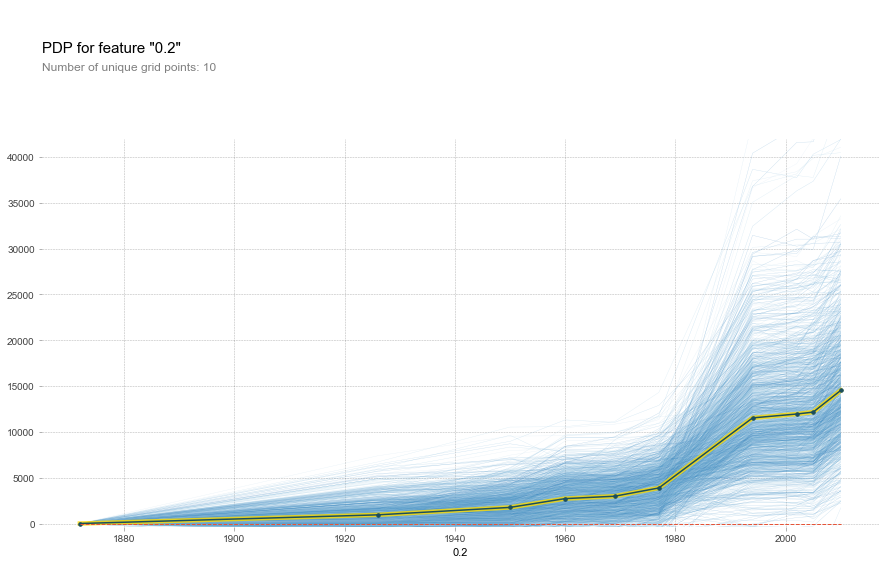

In [67]:
#plot_pdp(model, 'OverallQual', df_new)
plot_pdp(model, 'YearBuilt', df_new)
#plot_pdp(model, 'TotalBsmtSF', df_new)
#plot_pdp(model, 'GarageCars', df_new)

### GradientBoostingRegressor

The final model we can test before more EDA is the `GradientBoostingRegressor`. With this model the features are randomly permutated with each split, which gives a varying degree of results. Let's try to fit a simple model and Hypertune it too.

In [68]:
from sklearn.ensemble import GradientBoostingRegressor

In [69]:
mdl = GradientBoostingRegressor(n_estimators=100, alpha=0.01)
mdl.fit(X_train, y_train)
print_score(mdl, X_train, X_test, y_train, y_test)

[15220.484233861773, 22759.331244356672, 0.9653195287279419, 0.8993213213438849]


[15220.484233861773,
 22759.331244356672,
 0.9653195287279419,
 0.8993213213438849]

In [70]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

for lr in learning_rates:
    print(lr)
    mdl = GradientBoostingRegressor(n_estimators=100, learning_rate=lr)
    mdl.fit(X_train, y_train) 
    print_score(mdl, X_train, X_test, y_train, y_test)

0.05
[19098.38227758969, 22982.16365219519, 0.9453964076914936, 0.8973402175910317]
0.1
[15220.484233861773, 22431.34535944237, 0.9653195287279419, 0.902202183717531]
0.25
[10257.37221927705, 22986.460405477817, 0.984249284673627, 0.8973018273856368]
0.5
[6352.800225627347, 26724.86096500216, 0.9939583098552146, 0.8611808366340998]
0.75
[4520.947053415417, 28979.3425355889, 0.9969402433096489, 0.8367716576499185]
1
[3821.4375346672196, 31651.117558872364, 0.9978138418246678, 0.8052862541626689]


In [71]:
max_features = ['auto', None, 'sqrt','log2', 0.5, 0.9, 0.2]
for f in max_features:
    print(f)
    mdl = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_features=f)
    mdl.fit(X_train, y_train) 
    print_score(mdl, X_train, X_test, y_train, y_test)

auto
[15220.484233861773, 22518.378482830267, 0.9653195287279419, 0.9014418047228197]
None
[15220.484233861773, 22496.6754272201, 0.9653195287279419, 0.9016316925703136]
sqrt
[17312.97689353031, 25998.498674539347, 0.9551284005619384, 0.8686242969914353]
log2
[17493.553537492186, 24859.654433129173, 0.9541874856250047, 0.8798818351758764]
0.5
[15757.114868304177, 22101.04689766047, 0.9628309506686814, 0.9050610977129506]
0.9
[15372.95197273087, 21785.333764345094, 0.96462124122448, 0.9077541260789321]
0.2
[16475.42812535886, 22962.447882457072, 0.9593648872582593, 0.8975162800791158]


In [72]:
max_depth= [1,2,3,5,6,10]
for d in max_depth:
    print(d)
    mdl = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_features=0.9, max_depth=d)
    mdl.fit(X_train, y_train) 
    print_score(mdl, X_train, X_test, y_train, y_test)

1
[28322.98551367124, 28994.896430380904, 0.8799102027003367, 0.8365963936467762]
2
[20286.55834087818, 24632.45817959683, 0.9383909091776762, 0.8820673596374455]
3
[15214.846324814931, 22136.652502978966, 0.9653452163640097, 0.9047549511272149]
5
[6450.4011201636085, 22778.49309234668, 0.9937712414582089, 0.8991517204324727]
6
[3809.5675886105328, 23343.88774975945, 0.9978274017888307, 0.8940831914800007]
10
[45.569436332090014, 25071.28361963142, 0.9999996891324685, 0.8778280084474681]


In [73]:
estimators = [10, 100, 200, 400, 500, 1000]

for e in estimators:
    print(e)
    mdl = GradientBoostingRegressor(n_estimators=e, learning_rate=0.1, max_features=0.9, max_depth=3)
    mdl.fit(X_train, y_train) 
    print_score(mdl, X_train, X_test, y_train, y_test)

10
[43776.877359644335, 40106.01921002168, 0.7131085464723297, 0.6873649767436598]
100
[15152.335290962423, 22570.607516851553, 0.9656293935567863, 0.9009840835775381]
200
[11511.776137341427, 21995.10969558292, 0.9801613222770481, 0.9059690598751123]
400
[6976.011909923131, 21965.01501339342, 0.992714783239076, 0.9062261984252733]
500
[5830.438447988915, 22389.935616846786, 0.9949110230821007, 0.9025629328612995]
1000
[2474.3849320855206, 21840.37340921618, 0.9990834364630243, 0.907287427351466]


### Results

Using the GradientBooster we get an accuracy of around **90%** and an RMSE of $ **21879.60** which is an improvement over the other models.

In [74]:
mdl_final = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_features=0.9, max_depth=3)
mdl_final.fit(X_train, y_train) 
print_score(mdl_final, X_train, X_test, y_train, y_test)

[2430.7579046305896, 21879.602752535517, 0.9991154722452664, 0.9069540704363693]


[2430.7579046305896,
 21879.602752535517,
 0.9991154722452664,
 0.9069540704363693]

### Next Steps

Next steps are to understand the features more by applying further EDA techniques to improve the model. 